In [13]:
import json
import os

import numpy as np
import pandas as pd
import seaborn as sns
print(os.getcwd())

with open('./solar-3.log', 'r') as file:
    data_str = file.read().replace("'",'"')[:-2]
    # data_json = json.loads(f"[{data_str}]")
    data = pd.read_json(f"[{data_str}]")


/Users/mirkobristle/Git/MTGNN


Index(['name', 'type', 'epoch', 'iter', 'loss', 'time', 'train_loss',
       'train_rse', 'train_rae', 'train_corr', 'valid_rse', 'valid_rae',
       'valid_corr', 'test_rse', 'test_rae', 'test_corr'],
      dtype='object')


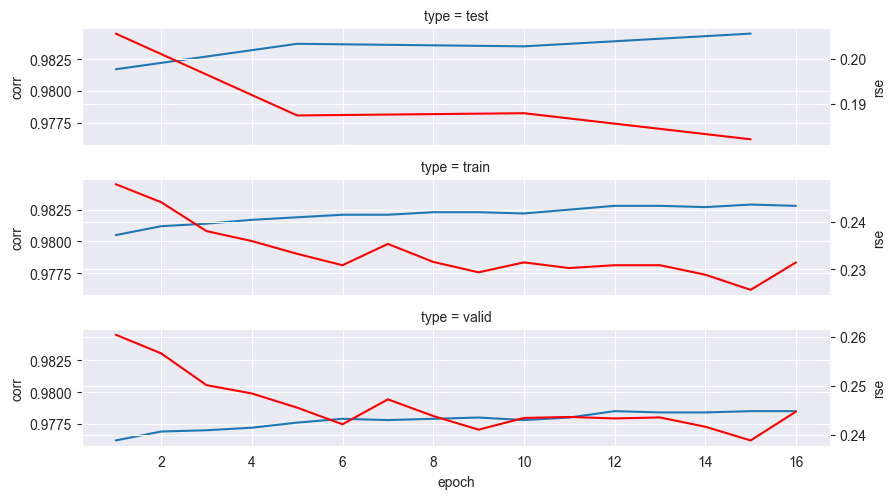

In [14]:
import numpy as np
df = data[data['type']!= 'loss']
df.loc[df['valid_rse']>-1, 'type'] = 'valid'
print(df.keys())
del df["iter"], df["loss"]
df_long = pd.melt(df,id_vars=['name','type', 'epoch'],value_vars=['train_rse', 'train_rae', 'train_corr', 'valid_rse', 'valid_rae', 'valid_corr', 'test_rse', 'test_rae', 'test_corr'])
df_long[['data_type','metric']] = df_long['variable'].str.split('_',expand=True)
df_long = df_long[df_long['value'].notna()]
#df.pivot(index='patient', columns='obs', values='score')
df_wide = df_long.pivot(index=['name','type','epoch'], columns='metric', values='value').reset_index()

# TODO filter for type and horizon
g = sns.FacetGrid(df_wide, row="type",height=1.7, aspect=5)
g.map(sns.lineplot, "epoch", "corr")
for name in g.axes_dict:
    sub_plot =g.axes_dict[name]
    ax2 = sub_plot.axes.twinx()
    sns.lineplot(df_wide.loc[df_wide['type']==name],x='epoch',y='rse',color='red',ax = ax2,errorbar=None)

In [10]:
from util import DataLoaderS
import torch

device = torch.device("mps")
model = torch.load("model-solar-3.pt")

Data = DataLoaderS("./data/solar_AL.txt", 0.6, 0.2, device, 3,168, 2)

predict = None
test = None


for X, Y in Data.get_batches(Data.train[0], Data.train[1], 4, False):
    X = torch.unsqueeze(X, dim=1)
    X = X.transpose(2, 3)
    with torch.no_grad():
        output = model(X)
    output = torch.squeeze(output)
    if len(output.shape) == 1:
        output = output.unsqueeze(dim=0)
    if predict is None:
        predict = output
        test = Y
    else:
        predict = torch.cat((predict, output))
        test = torch.cat((test, Y))



<AxesSubplot: ylabel='Count'>

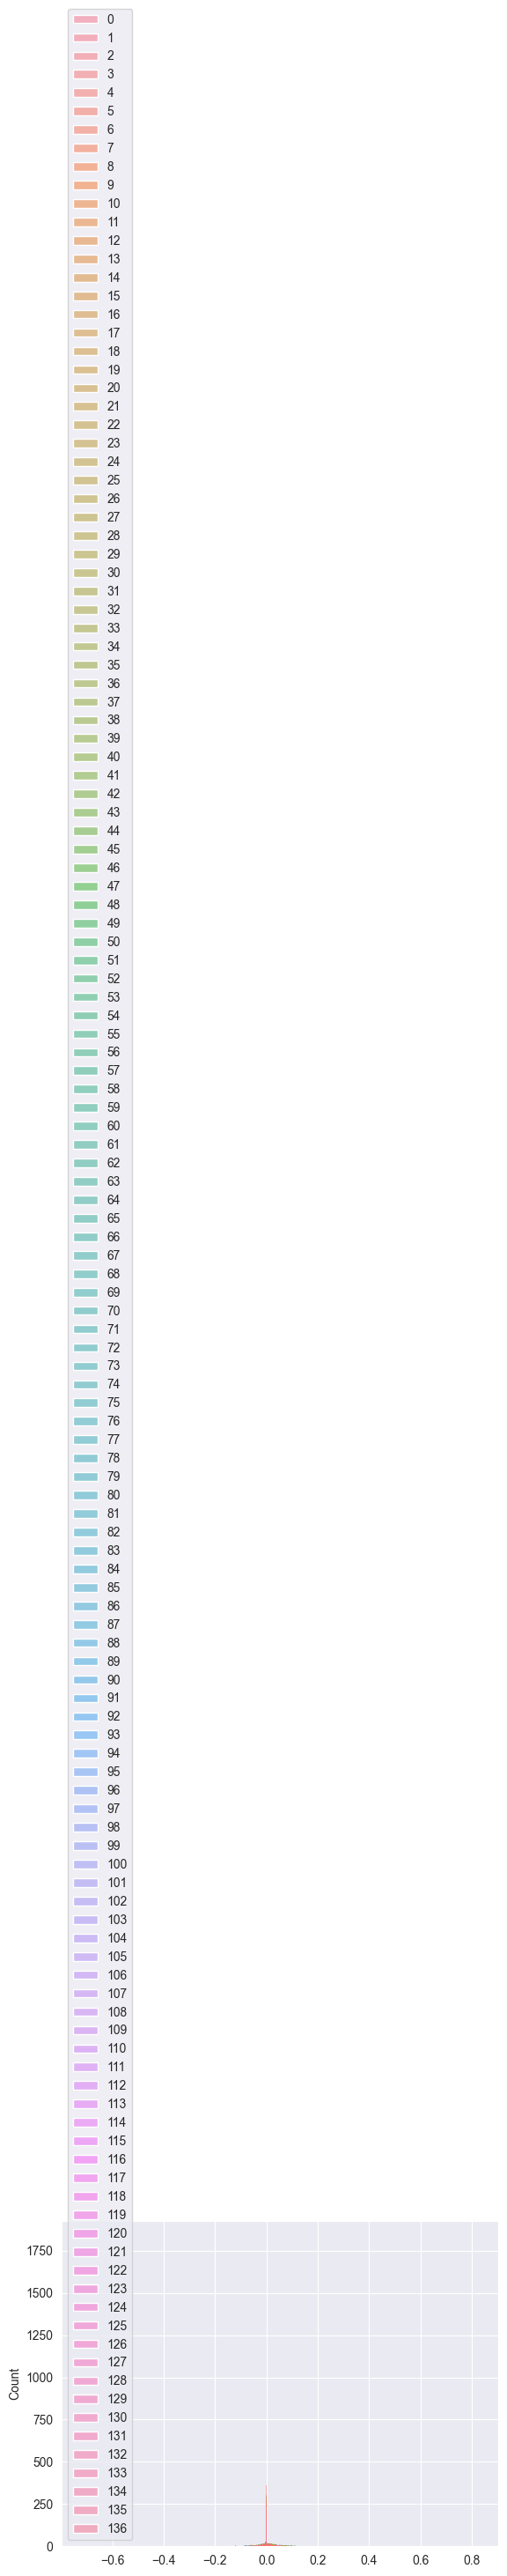

In [12]:
import  seaborn as sns
Ypredict = predict.data.cpu().numpy()
Ytest = test.data.cpu().numpy()



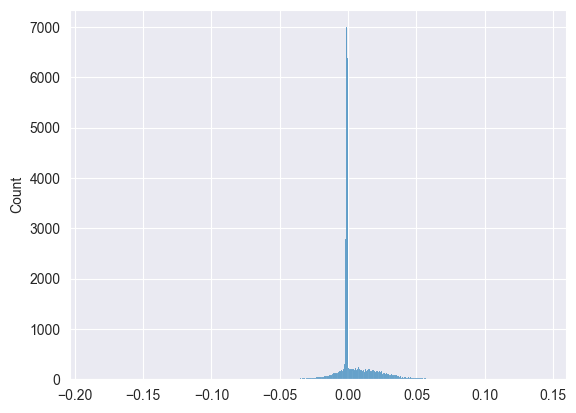

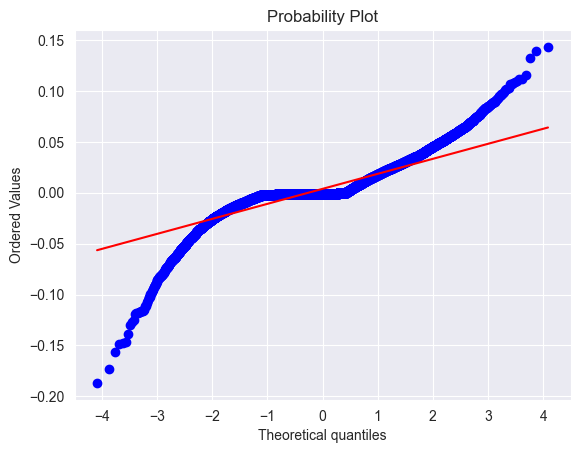

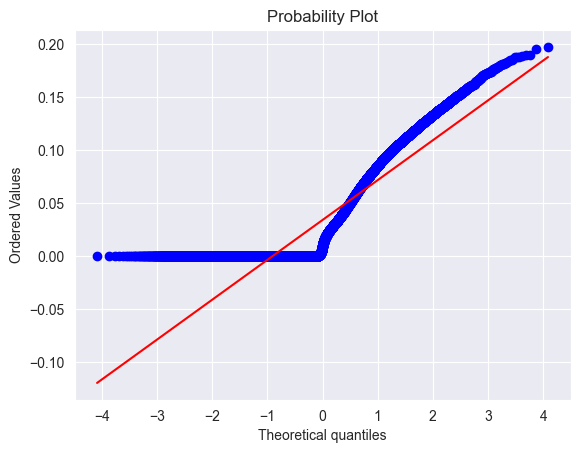

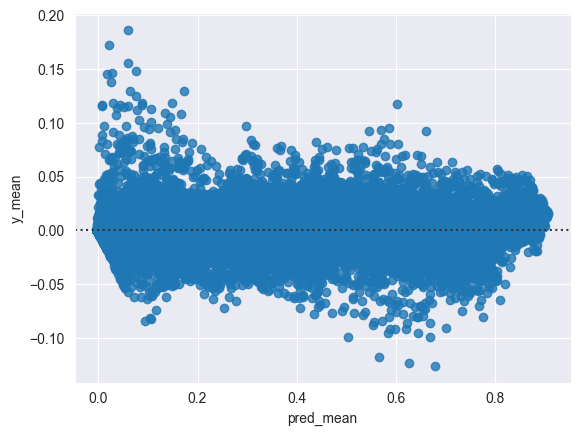

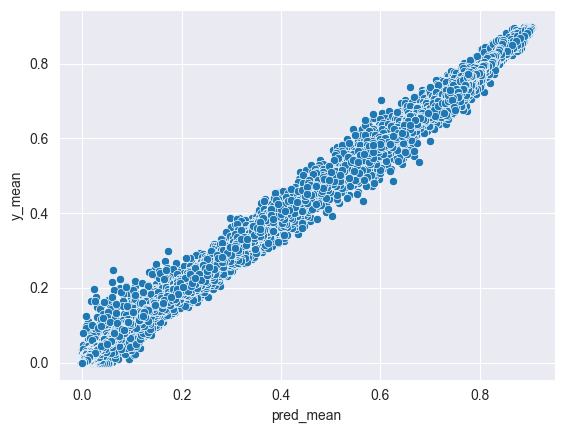

<AxesSubplot: xlabel='pred_std', ylabel='y_std'>

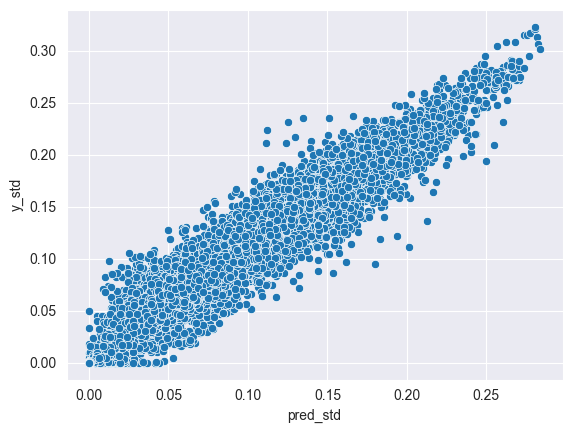

In [47]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
df = pd.DataFrame({"pred_mean": Ypredict.mean(axis=1),"y_mean":Ytest.mean(axis=1),"pred_std": Ypredict.std(axis=1),"y_std":Ytest.std(axis=1)})

Ydiff = Ypredict-Ytest
sns.histplot((Ydiff.mean(axis=1)))
plt.show()
stats.probplot(Ydiff.mean(axis=1), dist="norm", plot=plt)
plt.show()
stats.probplot(Ydiff.std(axis=1), dist="norm", plot=plt)
plt.show()
sns.residplot(data=df,x="pred_mean",y="y_mean")
plt.show()
sns.scatterplot(df,x="pred_mean",y="y_mean")
plt.show()
sns.scatterplot(df,x="pred_std",y="y_std")

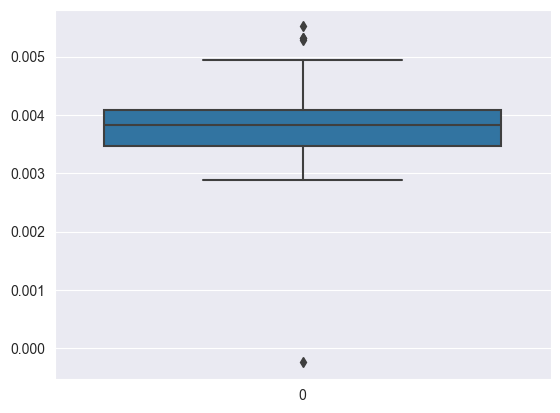

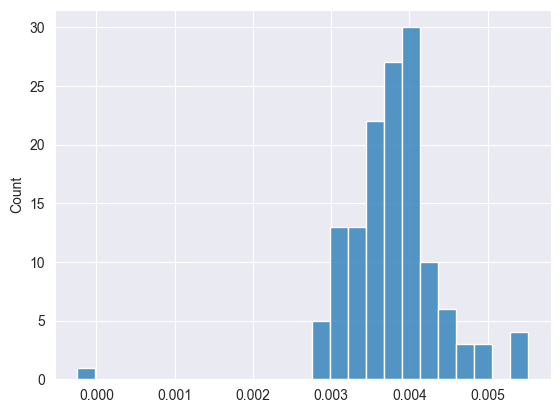

<AxesSubplot: >

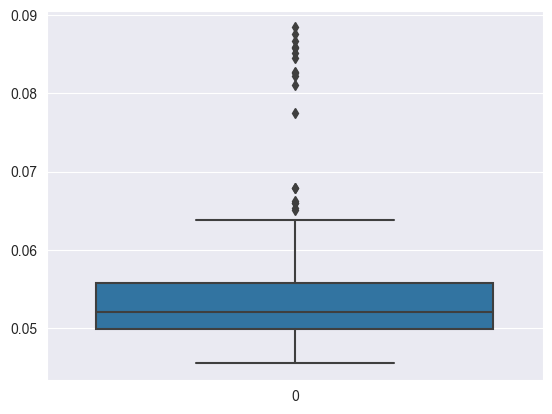

In [57]:
sns.boxplot(Ydiff.mean(axis=0),)
plt.show()
sns.histplot(Ydiff.mean(axis=0),)
plt.show()
sns.boxplot(Ydiff.std(axis=0),)